In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import random as rm
import numpy as np
from numpy.random import default_rng

rng = default_rng()

In [3]:
def str2int_arr(str):
    return [float(i) for i in str]

def graph_from_file(file):
    w = []
    with open(file, "r") as f:
        for line in f:
            arr = line.split()
            map(int, arr)
            w.append(str2int_arr(arr))
    return nx.from_numpy_matrix(np.array(w))

def graph_from_dimacs(file):
    G = nx.Graph()
    with open(file, "r") as f:
        for line in f:
            buff = line.split()
            if buff[0]=="p":
                G.add_nodes_from([i for i in range(1, int(buff[2])+1 )])
                break
        for line in f:
            edge = line.split()
            G.add_edge(int(edge[1]), int(edge[2]))
    return G

G = graph_from_file("graph_examples/34_14")

In [12]:


def digits_from_01(arr):
    digits = []
    for i in range(len(arr)):
        if int(arr[i]) == 1:
            digits.append(i) 
    return digits
    

def initial_population(n, size):
    population = []
    for _ in range(size):
        individual = ""
        for _ in range(n):
            individual += rm.choice("0")
        population.append(individual)
    return population
    
def adaptability(G, individual, B=2):
    subgraph_v = np.array([], dtype="int")
    
    for i in range(individual.size):
        if individual[i]==1:
            subgraph_v = np.append(subgraph_v, [i])
            
    subgraph = nx.subgraph(G, list(subgraph_v))
    n = subgraph_v.size
    return max((-n*(n-1)//2 + subgraph.number_of_edges()) * B + n, 1) #max(n-(n*(n-1)//2 + subgraph.number_of_edges())*fine, 1)

def roulette(population, k):
    
    population_weights = [adaptability(G, i) for i in population]
    #if sum(population_weights)==0 :
    #    population_weights = [1 for _ in range(len(population_weights))]
    descendants = rm.choices(population, population_weights, k=k)
    
    return descendants

def crossover(parents):
    point = rm.randint(0, parents[0].size)
    child = np.concatenate((parents[0][:point], parents[1][point:]))
    return child 

def mutation(individual, probability = 0.5):
    if rm.random()>probability:
        return individual
    
    point = rm.randint(0, individual.size-1)
    
    individual[point] ^= 1
    
    return individual

def multy_mutation(individual):
    num_mutation=5
    n = individual.size
    for i in range(num_mutation):
        individual[np.random.randint(0, n)] ^= 1
    
    return individual

def print_p(population):
    for i in population:
        for j in i:
            print(j, end='')
        print()


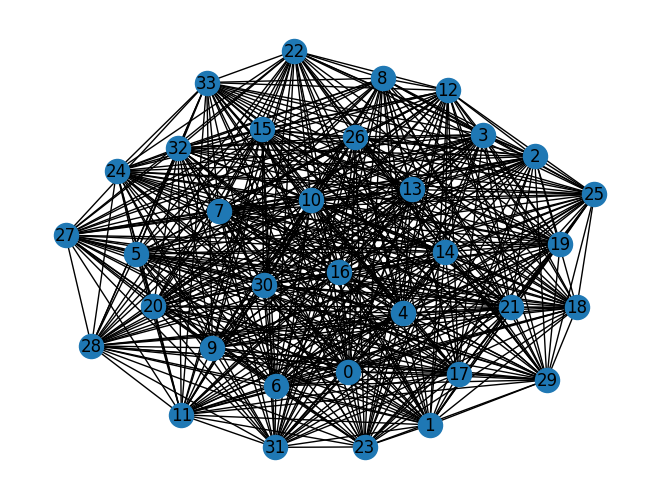

In [5]:

#G = graph_from_dimacs("DIMACS_subset_ascii/C125.9.clq")
nx.draw(G, with_labels=True)

In [19]:
G = graph_from_file("graph_examples/34_14")
#----------Hyperparameters----------
p_size = 20
np_size = 20
max_iteration = 10000
elite_size = 3
estimated_click_size = 14
#-----------#-----------#----------- 

population = np.zeros((p_size, G.number_of_nodes()), dtype="byte")  # np.array(initial_population(n, p_size), dtype="str")
population = np.array(list(map(multy_mutation, population)), dtype="byte")
p_adaptability = np.array([adaptability(G, ind) for ind in population], dtype="int")

new_population = np.zeros((p_size, G.number_of_nodes()), dtype="byte")
new_p_adaptability = np.zeros(p_size, dtype="int")

for iteration in range(max_iteration):
    # выбор родителей + скрещивание + мутация
    for i in range(np_size):
        new_population[i] = mutation(crossover( rm.choices(population, p_adaptability, k=2) ), probability=0.6 )#  ???
        new_p_adaptability[i] = adaptability(G, new_population[i], B=1)
    
    # сортировка по приспособленности  
    #p_adaptability = [adaptability(G, ind) for ind in population]
    #p_adaptability, pop_sort = (list(t) for t in zip(*sorted(zip(p_adaptability, population), reverse=True)))

    # выбор новой популяции
    new_population = np.concatenate((population, new_population[:p_size]))
    new_p_adaptability = np.concatenate((p_adaptability, new_p_adaptability[:p_size]))
    
    new_num = rm.choices(np.arange(p_size*2), new_p_adaptability, k=p_size)  # the numbers of individuals for the new population
    
    elite_index = np.argsort(new_p_adaptability)[::-1][:elite_size]
    
    for i in range(elite_size):
        population[i] = new_population[elite_index[i]]
        p_adaptability[i] = new_p_adaptability[elite_index[i]]
    for i in range(elite_size, p_size):
        population[i] = new_population[new_num[i]]
        p_adaptability[i] = new_p_adaptability[new_num[i]]
        
    
    if max(p_adaptability)>=estimated_click_size:
        break
    
    
print(p_adaptability)
print_p(population)

print(iteration)


[14 13 13 13 13 13 10 13 12 13 10 13 10 10 10 13 13 13 12 13]
1000100011010101010101001100001100
1000100011010101010101000111011100
1000100011010101010101000100001100
1000100011010101010101001110001100
1000100011010101010101000101001100
1000100011010101010101001101001100
1000100011010101010101001111101100
1000100011010101010101001101001100
1000100011011101010101000111001100
1000000011010101010101001100001100
1000100011010100011101001001001100
1000100011010101010101000101001100
1000100011010100011101001001001100
1000100011010100011101001001001100
1000100011010101110101001101001100
1000100011010101010101000011001100
1000100011010101010101001101001100
1000100011010101010101000011001100
1000100011010101010101101101001100
1000100011010101010101000011001100
2453


In [23]:
G = graph_from_dimacs("DIMACS_subset_ascii/C125.9.clq")
#----------Hyperparameters----------
p_size = 40
np_size = 40
max_iteration = 1000
elite_size = 5
estimated_click_size = 34
#-----------#-----------#----------- 

population = np.zeros((p_size, G.number_of_nodes()), dtype="byte")  # np.array(initial_population(n, p_size), dtype="str")
population = np.array(list(map(multy_mutation, population)), dtype="byte")
p_adaptability = np.array([adaptability(G, ind) for ind in population], dtype="int")

new_population = np.zeros((p_size, G.number_of_nodes()), dtype="byte")
new_p_adaptability = np.zeros(p_size, dtype="int")


for iteration in range(max_iteration):
    # выбор родителей + скрещивание + мутация
    for i in range(np_size):
        new_population[i] = mutation(crossover( rm.choices(population, p_adaptability, k=2) ), probability=0.6 )#  ???
        new_p_adaptability[i] = adaptability(G, new_population[i], B=1)
    
    # сортировка по приспособленности  
    #p_adaptability = [adaptability(G, ind) for ind in population]
    #p_adaptability, pop_sort = (list(t) for t in zip(*sorted(zip(p_adaptability, population), reverse=True)))

    # выбор новой популяции
    new_population = np.concatenate((population, new_population[:p_size]))
    new_p_adaptability = np.concatenate((p_adaptability, new_p_adaptability[:p_size]))
    
    new_num = rm.choices(np.arange(p_size*2), new_p_adaptability, k=p_size)  # the numbers of individuals for the new population
    
    elite_index = np.argsort(new_p_adaptability)[::-1][:elite_size]
    
    for i in range(elite_size):
        population[i] = new_population[elite_index[i]]
        p_adaptability[i] = new_p_adaptability[elite_index[i]]
    for i in range(elite_size, p_size):
        population[i] = new_population[new_num[i]]
        p_adaptability[i] = new_p_adaptability[new_num[i]]
        
    
    if max(p_adaptability)>=estimated_click_size:
        break
    
    
print(p_adaptability)
print_p(population[:5])

print(iteration)

[30 30 30 30 30 29 25 29 27 25 30 30 30 30 29 30 29 29 28 29 30 30 21 30
 29 30 30 29 30 21 30 30 27 29 29 25 30 30 29 30]
01100100010100100101000011000111001000010100000000001000010000000000000000000001110001100000000000111100010100100000000101000
01100100010100100101000011000111001000010100000000001000010000000000000000000001110001100000000000111100010100100000000101000
01100100010100100001000011000111001000010100000000001000010000000000000000000001110001100000000000111100010100100001000101000
01100100010100100001000011000111001000010100000000001000010000000000000000000001110001100000000000111100010100100001000101000
01100100010100100001000011000111001000010100000000001000010000000000000000000001110001100000000000111100010100100000000101000
999
